In [52]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

In [53]:
# Define the transformations on the data
low_res_size = 128
high_res_size = 256


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

denormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor(),
   # transforms.Normalize(std = std , mean = mean)
    
])


transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor(),
    #transforms.Normalize(std = std , mean = mean)
])

In [54]:
class ImageDataset(Dataset):
    # This is a custom dataset created using pytorch Dataset
    def __init__(self, root_dir):
        super(ImageDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        files_low = os.listdir(os.path.join(root_dir, "low_res"))
        files_high = os.listdir(os.path.join(root_dir, "high_res"))
        self.data = list(zip(files_low, files_high))

        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]
        
        # Get the path for the image LR and HR
        low_res_pth = os.path.join(self.root_dir, "low_res", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "high_res", img_high_file)

        # Open the actual image
        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))
        
        # Discarding the alpha channel to make the model more optimized for memory
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]
        
        # Apply the transformation to the image
        low_res = transform_low(low_res)
        high_res = transform_high(high_res)
        
        return low_res, high_res

#### define the hyperparameters

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
epochs = 61
batch_size = 16
num_workers = 2
img_channels = 3

In [56]:
# listing the model to take the required subset of it
test_vgg_model = vgg19(weights=True).eval().to(device)
lf = list(test_vgg_model.features)
lf[25]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [57]:
class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

In [58]:
class ConvBlock(nn.Module):
    # Conv -> BN -> leakyReLU
    def __init__(
            self,
            in_channels,
            out_channels,
            use_activation=True,
            use_BatchNorm=True,
            **kwargs
    ):
        
        super().__init__()
        self.use_activation = use_activation
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.ac = (
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x1 = self.cnn(x)
        x2 = self.bn(x1)
        x3 = self.ac(x2)
        return x3 if self.use_activation else x2

In [59]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, 2, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))

In [60]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.b2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_activation=False
        )

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        return out + x

In [61]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for i in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2)) 
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        return torch.sigmoid(self.final(c))

In [62]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride = idx % 2 + 1,
                    padding=1,
                    use_activation=True,
                    use_BatchNorm=idx != 0,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512*8*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x

In [63]:
def plot_examples(gen):
    dataset_test = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/val")
    loader = DataLoader(dataset_test, batch_size=16, num_workers=2)
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    chosen_batch = random.randint(0, len(loader)-1)
    for idx, (low_res, high_res) in enumerate(loader):
        if(chosen_batch == idx):
            chosen = random.randint(0, len(low_res)-1)
        
            axs[0].set_axis_off()
            axs[0].imshow(low_res[chosen].permute(1, 2, 0))
            axs[0].set_title("low res")

            with torch.no_grad():
                upscaled_img = gen(low_res[chosen].to(device).unsqueeze(0))
        
            axs[1].set_axis_off()
            axs[1].imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
            axs[1].set_title("predicted")
        
            axs[2].set_axis_off()
            axs[2].imshow(high_res[chosen].permute(1, 2, 0))
            axs[2].set_title("high res")
        
            if(idx == 1):
                break
            
    # Show the figure
    plt.show()      
    
    gen.train()

In [64]:
gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

In [65]:
# the data loaders for training and validation
train = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/train")
train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers)

val = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/val")
val_loader = DataLoader(val, batch_size=batch_size, num_workers=num_workers)

In [66]:
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    loop = tqdm(train_loader)
    disc_loss = 0
    gen_loss = 0

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(device)
        low_res = low_res.to(device)
        
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)
        
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        
        disc_loss = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

            
    return gen_loss.detach().cpu(), disc_loss.detach().cpu()

In [ ]:
d_losses = []
g_losses = []
for epoch in range(epochs):
    plot_examples(gen)
    print("epoch ", epoch+1, "/", epochs)
    
    gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)

    d_losses.append(disc_loss)
    g_losses.append(gen_loss)
    if epoch % 5 == 0:
        torch.save(gen.state_dict(), "/kaggle/working/gen.pth")
        torch.save(disc.state_dict() ,  "/kaggle/working/disc.pth")
     


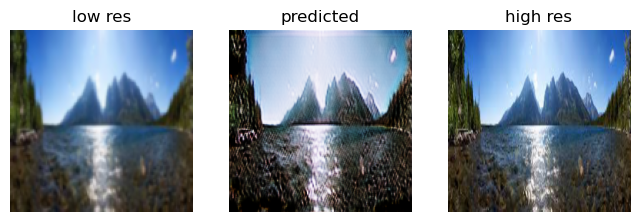

In [74]:
plot_examples(gen)

In [80]:
torch.save(gen, "/kaggle/working/gen_model")